In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

tf.reset_default_graph()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Visualizing an image data set sample

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


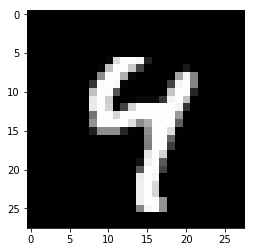

In [5]:
img = mnist.train.images[2]
label = mnist.train.labels[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print(label)


Defining the network 

In [200]:
def conv_net(inputs, keep_prob):
    conv = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)
    
    conv = tf.layers.max_pooling2d(conv,(2,2), padding='same')

    conv = tf.layers.conv2d(conv, 64, (5,5), padding='same', activation=tf.nn.relu)

    conv = tf.layers.max_pooling2d(conv,(2,2), padding='same')
        
    conv = tf.contrib.layers.flatten(conv)
    
    conv = tf.contrib.layers.fully_connected(conv, 1024, activation_fn=tf.nn.relu)
        
    conv = tf.nn.dropout(conv, keep_prob)

    conv = tf.contrib.layers.fully_connected(conv, 10, activation_fn=None)

    return conv

In [201]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='x')
y = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y')
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
lr = tf.placeholder(tf.float32, shape=[])

logits = conv_net(x, keep_prob)

logits = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

TypeError: max_pooling2d() missing 1 required positional argument: 'strides'

Network training hyper parameters

In [195]:
epochs = 10
batch_size = 512
keep_probability = 0.5
learning_rate = 0.00001

Training network

In [196]:
#Training helper functions    

def train_neural_network(session, optimizer, keep_probability, learning_rate, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: keep_probability,
        lr: learning_rate
    })
    
def print_training_stats(session, epoch, batch_i, feature_batch, label_batch, validation_feature, validation_label, cost, accuracy):
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.0})
    validation_accuracy = sess.run(accuracy, feed_dict={
                x: validation_feature,
                y: validation_label,
                keep_prob: 1.0 })
    print('Epoch {:>2}, MNIST Batch {}: Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(epoch + 1, batch_i, loss, validation_accuracy))
    

In [197]:
save_model_path = './numbers_network_model'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_features = batch[0].reshape((-1, 28, 28, 1))
            batch_labels = batch[1]
            train_neural_network(sess, optimizer, keep_probability, learning_rate, batch_features, batch_labels)
            
            print_training_stats(sess, epoch, i, 
                                 batch_features, batch_labels, 
                                 mnist.validation.images.reshape((-1, 28, 28, 1)), mnist.validation.labels,
                                 cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    sess.close()

Training...
Epoch  1, MNIST Batch 0: Loss:     2.2997 Validation Accuracy: 0.047000
Epoch  1, MNIST Batch 1: Loss:     2.3024 Validation Accuracy: 0.051200
Epoch  1, MNIST Batch 2: Loss:     2.3032 Validation Accuracy: 0.057800
Epoch  1, MNIST Batch 3: Loss:     2.2961 Validation Accuracy: 0.066000
Epoch  1, MNIST Batch 4: Loss:     2.2896 Validation Accuracy: 0.076400
Epoch  1, MNIST Batch 5: Loss:     2.2904 Validation Accuracy: 0.086400
Epoch  1, MNIST Batch 6: Loss:     2.2876 Validation Accuracy: 0.095600
Epoch  1, MNIST Batch 7: Loss:     2.2890 Validation Accuracy: 0.109200
Epoch  1, MNIST Batch 8: Loss:     2.2794 Validation Accuracy: 0.121400
Epoch  1, MNIST Batch 9: Loss:     2.2785 Validation Accuracy: 0.139400
Epoch  1, MNIST Batch 10: Loss:     2.2732 Validation Accuracy: 0.155200
Epoch  1, MNIST Batch 11: Loss:     2.2686 Validation Accuracy: 0.170800
Epoch  1, MNIST Batch 12: Loss:     2.2768 Validation Accuracy: 0.188000
Epoch  1, MNIST Batch 13: Loss:     2.2665 Valida

Testing the model predictions

In [198]:
# Testing helpers

def display_image_predictions(features, labels, predictions, n_classes):
   
    label_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        axies[image_i][0].imshow(feature.reshape((feature.shape[0],feature.shape[1])))
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


INFO:tensorflow:Restoring parameters from ./numbers_network_model
Testing Accuracy: 0.09498355263157894



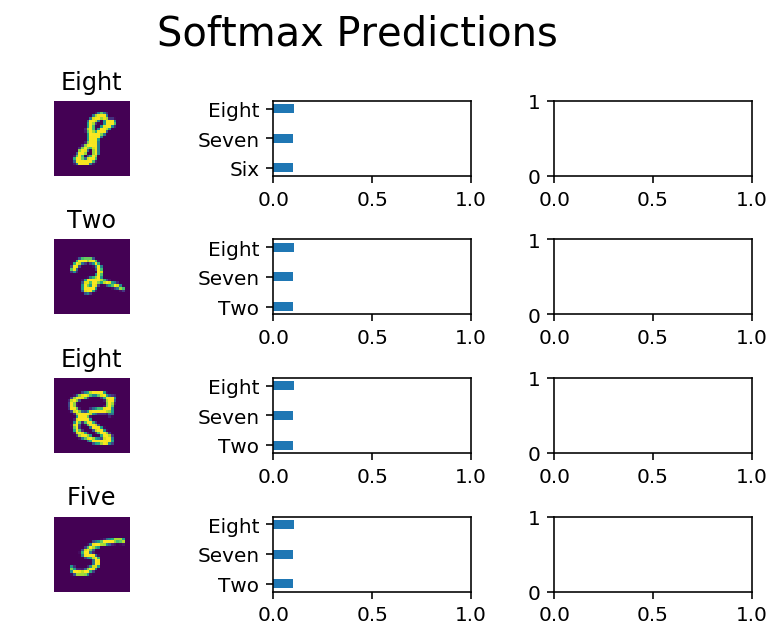

In [199]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

n_samples = 4
top_n_predictions = 3

def test_model():
    
    test_features = mnist.test.images.reshape((-1, 28, 28, 1))
    test_labels = mnist.test.labels
    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Getting Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for i in range(mnist.test.num_examples//batch_size):
            batch = mnist.test.next_batch(batch_size)
            test_feature_batch = batch[0].reshape((-1, 28, 28, 1))
            test_label_batch = batch[1]
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0 })
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, 10)
        sess.close()
test_model()
    